2023-03-16 14:12:14.893 
  command:

    streamlit run C:\Users\darka\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py [ARGUMENTS]


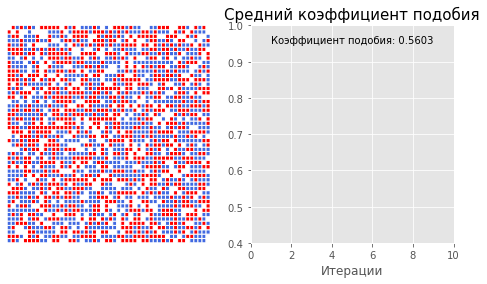

In [1]:
import random
import numpy as np
import streamlit as st

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


class Schelling:
    
    def __init__(self, size, empty_ratio, similarity_threshold, n_neighbors):
        self.size = size 
        self.empty_ratio = empty_ratio
        self.similarity_threshold = similarity_threshold
        self.n_neighbors = n_neighbors
        
        # Соотношение рас (-1, 1) и пустых домов (0)
        p = [(1-empty_ratio)/2, (1-empty_ratio)/2, empty_ratio]
        city_size = int(np.sqrt(self.size))**2
        self.city = np.random.choice([-1, 1, 0], size=city_size, p=p)
        self.city = np.reshape(self.city, (int(np.sqrt(city_size)), int(np.sqrt(city_size))))
    
    def run(self):
        for (row, col), value in np.ndenumerate(self.city):
            race = self.city[row, col]
            if race != 0:
                neighborhood = self.city[row-self.n_neighbors:row+self.n_neighbors, col-self.n_neighbors:col+self.n_neighbors]
                neighborhood_size = np.size(neighborhood)
                n_empty_houses = len(np.where(neighborhood == 0)[0])
                if neighborhood_size != n_empty_houses + 1:
                    n_similar = len(np.where(neighborhood == race)[0]) - 1
                    similarity_ratio = n_similar / (neighborhood_size - n_empty_houses - 1.)
                    is_unhappy = (similarity_ratio < self.similarity_threshold)
                    if is_unhappy:
                        empty_houses = list(zip(np.where(self.city == 0)[0], np.where(self.city == 0)[1]))
                        random_house = random.choice(empty_houses)
                        self.city[random_house] = race
                        self.city[row,col] = 0

    def get_mean_similarity_ratio(self):
        count = 0
        similarity_ratio = 0
        for (row, col), value in np.ndenumerate(self.city):
            race = self.city[row, col]
            if race != 0:
                neighborhood = self.city[row-self.n_neighbors:row+self.n_neighbors, col-self.n_neighbors:col+self.n_neighbors]
                neighborhood_size = np.size(neighborhood)
                n_empty_houses = len(np.where(neighborhood == 0)[0])
                if neighborhood_size != n_empty_houses + 1:
                    n_similar = len(np.where(neighborhood == race)[0]) - 1
                    similarity_ratio += n_similar / (neighborhood_size - n_empty_houses - 1.)
                    count += 1
        return similarity_ratio / count


 
#Streamlit App

st.title("Модель сегрегации Шеллинга")

population_size = st.sidebar.slider("Размер популяции", 500, 10000, 2500)
empty_ratio = st.sidebar.slider("Empty Houses Ratio", 0., 1., .2)
similarity_threshold = st.sidebar.slider("Порог сходства", 0., 1., .4)
n_iterations = st.sidebar.number_input("Количество итераций", 10)

schelling = Schelling(population_size, empty_ratio, similarity_threshold, 3)
mean_similarity_ratio = []
mean_similarity_ratio.append(schelling.get_mean_similarity_ratio())

#Строит графики на начальном этапе
plt.style.use("ggplot")
plt.figure(figsize=(8, 4))

# График с левой стороны с графиком моделирования по Шеллингу
cmap = ListedColormap(['red', 'white', 'royalblue'])
plt.subplot(121)
plt.axis('off')
plt.pcolor(schelling.city, cmap=cmap, edgecolors='w', linewidths=1)

# График с правой стороны со средним коэффициентом подобия
plt.subplot(122)
plt.xlabel("Итерации")
plt.xlim([0, n_iterations])
plt.ylim([0.4, 1])
plt.title("Средний коэффициент подобия", fontsize=15)
plt.text(1, 0.95, "Коэффициент подобия: %.4f" % schelling.get_mean_similarity_ratio(), fontsize=10)

city_plot = st.pyplot(plt)

progress_bar = st.progress(0)

if st.sidebar.button('Запустить симуляцию'):

    for i in range(n_iterations):
        schelling.run()
        mean_similarity_ratio.append(schelling.get_mean_similarity_ratio())
        plt.figure(figsize=(8, 4))
    
        plt.subplot(121)
        plt.axis('off')
        plt.pcolor(schelling.city, cmap=cmap, edgecolors='w', linewidths=1)

        plt.subplot(122)
        plt.xlabel("Итерации")
        plt.xlim([0, n_iterations])
        plt.ylim([0.4, 1])
        plt.title("Средний коэффициент подобия", fontsize=15)
        plt.plot(range(1, len(mean_similarity_ratio)+1), mean_similarity_ratio)
        plt.text(1, 0.95, "Коэффициент подобия: %.4f" % schelling.get_mean_similarity_ratio(), fontsize=10)

        city_plot.pyplot(plt)
        plt.close("all")
        progress_bar.progress((i+1.)/n_iterations)
